In [42]:
import codecs
import glob
import os
import re
import time
try:
    import cPickle as pickle
except:
    import pickle

import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import altair as alt

In [43]:

def genModelPreds_biasOC_d(outcomes,lr,d,p0):
    outcomes=np.array(outcomes)

    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes==-1]=-d
    ocsDf[outcomes==1]=1-d
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (ocsDf[:,ii] - pred[:,ii])
    return pred 

def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i for i in chVals]
    #are we considering sftmax to be temp, not inverse temp?
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i

    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]

    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    return actProbArr

def genChoices(actProbArr):
    probs = np.stack([a.to_numpy() for a in actProbArr], axis=0)  # (K, N, T)
    cum = np.cumsum(probs, axis=0)                                 # (K, N, T)
    u = np.random.random_sample(probs.shape[1:])                   # (N, T)
    # first k where u <= cum[k]
    choices = (u[None, :, :] <= cum).argmax(axis=0) + 1
    return choices



def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll


#single LR sofented with sigmoid and biasedOC with sigmoid and p0 with no sigmoid, + fixed SM model
def optimizeLR_sft_fixedSM_posNegOC_p0(params, choices, outcomes, smax=1):
    lrp,d, p0=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0 = (np.exp(p0)/(np.exp(p0)+1))*2 - 1 #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,p0)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    return np.sum(nLL)


In [44]:
def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return np.random.beta(alpha, beta,N)

In [45]:
def load_workspace(filename):
 with open(filename, 'rb') as f:
  data_loaded = pickle.load(f)
 return data_loaded

data = load_workspace('data/pklForTheo.pkl')

In [46]:
params_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\data\1LRp0D_TRUST.csv")
params_df = params_df[['PROLIFIC_PID', 'subjLR_3prm', 'subjD_3prm', 'subjp0_3prm']]
params_df = params_df.rename(columns={
    'subjLR_3prm': 'lr',
    'subjD_3prm': 'd',
    'subjp0_3prm': 'p0'
})
params_df['smax'] = 1
params_df = params_df.rename(columns={'PROLIFIC_PID': 'PID'})
subjParams = params_df.copy()


In [47]:
subjParams = subjParams.set_index('PID')
datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)
good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in subjParams.index]

subjParams = subjParams.loc[valid_candidates]

In [48]:

print("Parameter means and standard deviations in subjParams:")
for param in ['lr','d','p0']:
    print(f"{param}: mean={subjParams[param].mean():.4f}, std={subjParams[param].std(ddof=1):.4f}")

Parameter means and standard deviations in subjParams:
lr: mean=0.2635, std=0.2492
d: mean=0.6152, std=0.3588
p0: mean=0.0776, std=0.5291


In [49]:
ocDf = data['rwlrnOCArr']

In [50]:
len(ocDf["PID"].unique())
ocDf

,PID,"0.2,0.65","0.35,0.65","0.35,0.8","0.65,0.2","0.8,0.2","0.8,0.35","0.2,0.8","0.65,0.35"
0,5f2f86864fd821374b4367bc,1,0.0,0,1,1.0,1,NaN,NaN
1,5f2f86864fd821374b4367bc,1,0.0,0,0,1.0,1,NaN,NaN
2,5f2f86864fd821374b4367bc,0,0.0,0,1,0.0,1,NaN,NaN
3,5f2f86864fd821374b4367bc,1,0.0,0,1,1.0,1,NaN,NaN
4,5f2f86864fd821374b4367bc,0,1.0,0,1,1.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
17,620bdd8ca922fc3f247f6c82,0,NaN,1,0,0.0,0,NaN,1.0
18,620bdd8ca922fc3f247f6c82,1,NaN,1,0,0.0,0,NaN,0.0
19,620bdd8ca922fc3f247f6c82,0,NaN,1,0,0.0,0,NaN,1.0
20,620bdd8ca922fc3f247f6c82,0,NaN,1,1,0.0,0,NaN,0.0


In [51]:
import numpy as np
import pandas as pd
from scipy import stats

# -----------------------------
# SIM SETTINGS (yours unchanged)
# -----------------------------
nPtp = 100
""" lr_mu = 0.15
lrSTD = 0.05


d_mu = 0.5
d_std = 0.2

offer0_mu = 0.0
offer0_std = 0.5
 """
sftMax = 1
lr_mu = subjParams['lr'].mean()
lrSTD = subjParams['lr'].std(ddof=1)
d_mu = subjParams['d'].mean()
dSTD = subjParams['d'].std(ddof=1)
p0_mu = subjParams['p0'].mean()
p0STD = subjParams['p0'].std(ddof=1)
nTrialsPerTarget = 22
targConting = [[.2,.65], [.35,.8], [.65,.2], [.8,.35], [.2,.65], [.35,.8], [.65,.2], [.8,.35]]
switchRange = 5
conseqContingMin = 8
conditions = ['pSoc']

# -----------------------------
# OUTCOMES (yours unchanged)
# -----------------------------

ocArr = []
for ppt in np.arange(nPtp):
    for cond in conditions:
        for conting in targConting:
            switchPnt = np.floor(np.random.random_sample()*switchRange).astype(int) + conseqContingMin
            outcomes = np.concatenate((
                (np.random.random_sample(switchPnt) < conting[0]).astype(int),
                (np.random.random_sample(nTrialsPerTarget-switchPnt) < conting[1]).astype(int)
            ))
            outcomes = np.where(outcomes == 0, -1, 1)
            ocArr.append(['{:04d}'.format(ppt+1), cond, str(conting), switchPnt] + list(outcomes))

ocDf = pd.DataFrame(
    ocArr,
    columns=['PID', 'cond', 'conting', 'switchPnt'] + [f'oc_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
) 

# =========================================================
# NO-COVARIATE PARAMETER SIMULATION (this is the key change)
# =========================================================

# 1) sample lrs directly (bounded 0..1 via Beta parameterization around lr_mu, lrSTD)
#    - simplest: treat mu constant
lrs = betaMuSd(mu=lr_mu, sd=lrSTD, N=nPtp)

# 2) sample offer0 directly (bounded 0..1). use normal then clip (matches your existing style)
offer0s = np.random.normal(loc=p0_mu, scale=p0STD, size=nPtp)
offer0s = np.clip(offer0s, -1, 1)

#3 sample d directly bounded 0..1 via Beta parameterization around d_mu, d_std)
ds = betaMuSd(mu= d_mu, sd=dSTD, N=nPtp)


print('Offer0s Mu: {:0.4f}'.format(np.mean(offer0s)))
print('Offer0s Std: {:0.4f}'.format(np.std(offer0s, ddof=1)))
print('lrs Mu: {:0.4f}'.format(np.mean(lrs)))
print('lrs Std: {:0.4f}'.format(np.std(lrs, ddof=1)))

# subjParams now  has PID/lr/offer0/d
subjParams = pd.DataFrame({
    'PID': ocDf.PID.unique(),
    'lr': lrs,
    'd': ds,
    'p0': offer0s
})

# -----------------------------
# PREDICTIONS + CHOICES (unchanged)
# -----------------------------
cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'pred_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
predDf = pd.DataFrame(columns=cols)

for ptp,  lr, d, p0 in zip(subjParams.PID, subjParams.lr, subjParams.d, subjParams.p0):
    outcome_cols = [col for col in ocDf.columns if col.startswith('oc_')]
    ocs = ocDf[ocDf.PID == ptp][outcome_cols]
    if ocs.shape[1] == 0 or ocs.shape[0] == 0:
        print(f"Warning: No outcome columns for PID {ptp}")
        continue
    T = ocs.shape[1]
    initPred = np.full((ocs.shape[0],), p0)
    preds = genModelPreds_biasOC_d(ocs, lr, d, initPred)
    preds = np.concatenate((np.array(ocDf.loc[(ocDf.PID==ptp), :'switchPnt']), preds), axis=1)
    predDf = pd.concat([predDf, pd.DataFrame(preds, columns=cols)], ignore_index=True)

actProbs = calcActProbsPosNegOC(predDf.loc[:, predDf.columns.str.startswith('pred')], sftMax)
simChoices = genChoices(actProbs)

cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'ch_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
simChDf = pd.DataFrame(
    np.concatenate((np.array(predDf.loc[:, :'switchPnt']), simChoices), axis=1),
    columns=cols
)
subjParams

Offer0s Mu: 0.0704
Offer0s Std: 0.4968
lrs Mu: 0.2791
lrs Std: 0.2364


,PID,lr,d,p0
0,0001,0.201954,0.384971,-0.031909
1,0002,0.139571,0.849722,-0.318193
2,0003,0.232570,0.740861,-0.980222
3,0004,0.374041,0.336551,0.275347
4,0005,0.195282,0.319290,0.133053
...,...,...,...,...
95,0096,0.000022,0.948174,-0.644491
96,0097,0.060030,0.999937,0.539331
97,0098,0.365805,0.848885,0.057584
98,0099,0.782991,0.027472,0.001711


In [52]:
initCh=simChDf.groupby('PID').mean()['ch_01']
initP=predDf.groupby('PID').mean()['pred_01']

c:\Users\mnand\miniconda3\envs\jpy39\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
""" lrRange=[-2,-0.5,0.5,2,]
p0Range=[-2,-0.5,0.5,2,]
dRange = [-2,-0.5,0.5,2,]
a1,a2,a3 =np.meshgrid(lrRange,p0Range, dRange)
a1=a1.reshape(16,)
a2=a2.reshape(16,)
a3=a3.reshape(16,) """
a1=[0]
a2=[0]
a3=[0]
timer=time.time()
for lrVal, dVal, p0Val in zip(a1, a2, a3):
    fitsDF=pd.DataFrame(columns=['lr', 'd', 'p0','nll'], index=subjParams.PID)
    nll=10000;
    for PID in subjParams.PID:
        result=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrVal,dVal, p0Val,),(simChDf.loc[(simChDf.PID==PID),'ch_01':], ocDf.loc[(ocDf.PID==PID), 'oc_01':],sftMax),bounds=((-10,10),(-10,10),(-10,10)))
        fitsDF.loc[PID,'lr']=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        fitsDF.loc[PID,'d']=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        fitsDF.loc[PID,'p0']=np.exp(result.x[2])/(np.exp(result.x[2])+1)*2 - 1
        fitsDF.loc[PID,'nll']=result.fun
        
        # if result.fun<nll:
        #     nll=result.fun
        #     bestLR=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        #     bestP0=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        #     bestNLL=nll

print('finished at: {:02f}'.format(time.time()-timer))
    

finished at: 108.454429


In [54]:
r,p=stats.pearsonr(fitsDF['p0'],subjParams['p0'])
print('fitXog p0: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['d'],subjParams['d'])
print('fitXog d: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['lr'],subjParams['lr'])
print('fitXog lr: r={:.02f}, p={:.03f}'.format(r,p))

fitXog p0: r=0.96, p=0.000
fitXog d: r=0.83, p=0.000
fitXog lr: r=0.92, p=0.000


In [55]:
subjParams = subjParams.rename(columns={'offer0': 'p0'})

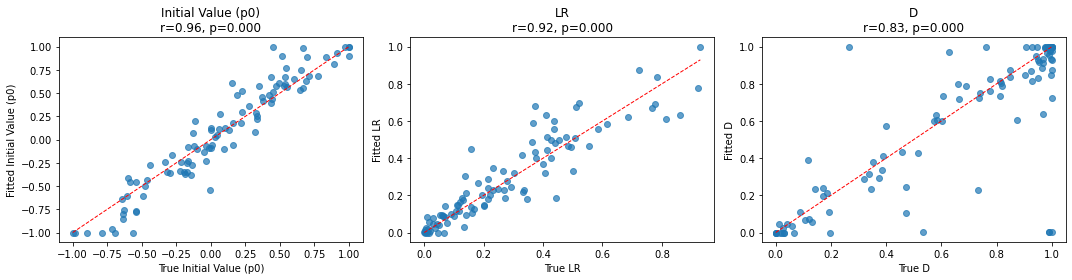

In [56]:
import matplotlib.pyplot as plt

params = ['p0', 'lr', 'd']
titles = {'p0': 'Initial Value (p0)', 'lr': 'LR', 'd': 'D'}

plt.figure(figsize=(15, 4))
for i, param in enumerate(params):
    plt.subplot(1, 3, i+1)
    plt.scatter(subjParams[param], fitsDF[param], alpha=0.7)
    plt.xlabel(f"True {titles[param]}")
    plt.ylabel(f"Fitted {titles[param]}")
    r, p = stats.pearsonr(fitsDF[param], subjParams[param])
    plt.title(f"{titles[param]}\nr={r:.2f}, p={p:.3f}")
    
    plt.plot([subjParams[param].min(), subjParams[param].max()],
             [subjParams[param].min(), subjParams[param].max()], 'r--', lw=1)

plt.tight_layout()
plt.show()

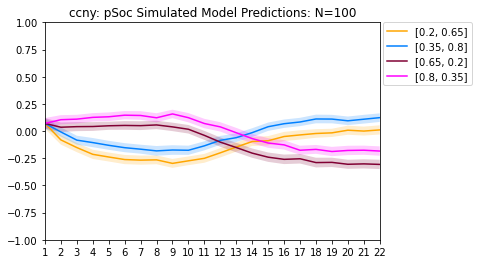

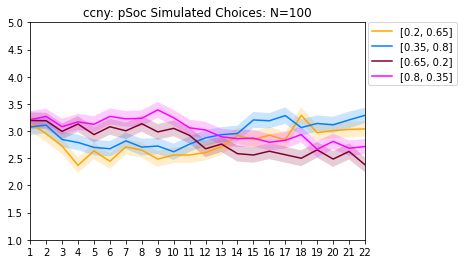

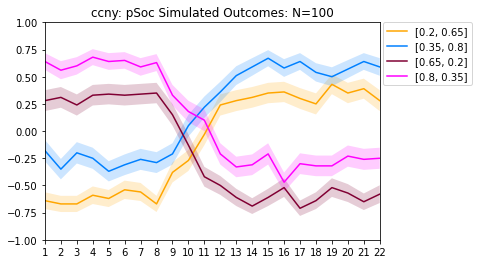

In [57]:
# plt.plot(simChDf.groupby('conting').mean().iloc[0,2:].transpose())

muCrvs=predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs=(predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_ch=simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_ch=(simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_oc=ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_oc=(ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()

colors=np.array([[1,.65,0], [0,.5,1], [.5,0,.2], [1,0,1]])
ind=0;
for conting in muCrvs.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu=np.squeeze(muCrvs.loc[(muCrvs.conting==conting), 'pred_01':].transpose())
    ste=np.squeeze(steCrvs.loc[(steCrvs.conting==conting), 'pred_01':].transpose())

    plt.plot(np.arange(1,mu.shape[0]+1),mu, c=col,label=conting)
    plt.fill_between(np.arange(1,mu.shape[0]+1),mu-ste,mu+ste, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Model Predictions: N={:d}'.format(cond,nPtp))
plt.legend(loc=(1.01,.71))
plt.ylim([-1,1])
plt.xlim([1,mu.shape[0]])
plt.xticks(np.arange(1,mu.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

ind=0
for conting in muCrvs_ch.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_ch=np.squeeze(muCrvs_ch.loc[(muCrvs_ch.conting==conting), 'ch_01':].transpose())
    ste_ch=np.squeeze(steCrvs_ch.loc[(steCrvs_ch.conting==conting), 'ch_01':].transpose())

    plt.plot(np.arange(1,mu_ch.shape[0]+1),mu_ch, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_ch.shape[0]+1),mu_ch-ste_ch,mu_ch+ste_ch, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Choices: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([1,5])
plt.xlim([1,mu_ch.shape[0]])
plt.xticks(np.arange(1,mu_ch.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('simCh_n{}_Grant.png'.format(nPtp))
plt.show()

ind=0
for conting in muCrvs_oc.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_oc=np.squeeze(muCrvs_oc.loc[(muCrvs_oc.conting==conting), 'oc_01':].transpose())
    ste_oc=np.squeeze(steCrvs_oc.loc[(steCrvs_oc.conting==conting), 'oc_01':].transpose())

    plt.plot(np.arange(1,mu_oc.shape[0]+1),mu_oc, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_oc.shape[0]+1),mu_oc-ste_oc,mu_oc+ste_oc, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Outcomes: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([-1,1])
plt.xlim([1,mu_oc.shape[0]])
plt.xticks(np.arange(1,mu_oc.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

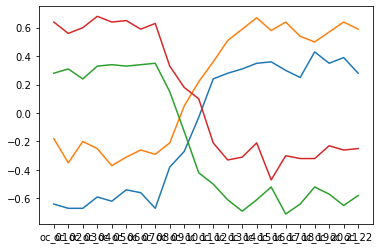

In [58]:
plt.plot(ocDf.groupby('conting').mean().loc[:,'oc_01':].transpose())
plt.show